# Ex 3: Transfer Functions Part 1
------------------------------------------------

## Notebook Initialization

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [20]:
%autoreload
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [10,10]

import numpy as np
from scipy.integrate import quad

import darkhistory.physics as physics
import darkhistory.spec.spectools as spectools
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
from darkhistory.spec.transferfunction import TransFuncAtRedshift

import darkhistory.electrons.ics.ics_spectrum as ics_spec

## Transfer Functions - Introduction

We call any function that maps one spectrum onto another a transfer function in this code. Mathematically, it is a function $T(E',E)$ such that

$$ \frac{dN'}{dE'} = \int T(E',E) \frac{dN}{dE} dE$$

where $\frac{dN'}{dE'}$ is some other spectrum. If $\frac{dN'}{dE'}$ is a delta function at energy $E_0$, then we see immediately that $\frac{dN'}{dE'} = T(E',E_0)$, so a transfer function $T(E',E)$ relates a delta function $\frac{dN}{dE}$ at energy $E$ to an output spectrum as a function of $E'$. 

One example is a secondary spectrum produced by some scattering process. Suppose that we have a process that, given a single primary particle of energy $E$, generates a spectrum of secondaries at some rate $\frac{dN_{\text{sec}}}{dE_{\text{sec}} dt}(E_{\text{sec}}, E)$. This spectrum can be viewed as the average spectrum of secondaries produced by many such primary particles scattering off some known background. Then for an incoming primary spectrum $\frac{dN}{dE}$, 

$$ \frac{dN_{\text{sec}}}{dE_{\text{sec}} dt} \times dt = \int \frac{dN_{\text{sec}}}{dE_{\text{sec}} dt} (E_{\text{sec}}, E) \times dt \cdot \frac{dN}{dE} dE $$

or, in terms of redshift, 

$$ \frac{dN_{\text{sec}}}{dE_{\text{sec}} dt} \times dt = \int \frac{dN_{\text{sec}}}{dE_{\text{sec}} dt} (E_{\text{sec}}, E) \times \frac{d \log z}{H(z)} \cdot \frac{dN}{dE} dE $$

So the transfer function in this case is

$$ T(E_{\text{sec}}, E, z) = \frac{dN_{\text{sec}}}{dE_{\text{sec}} dt} (E_{\text{sec}}, E) \times \frac{d \log z}{H(z)} $$

The discrete version of the transfer function, $\tau(E_{\text{sec}}^i, E^j, z^k)$ is

$$ \tau(E_{\text{sec}}^i, E^j, z^k) = \frac{dN_{\text{sec}}}{dE_{\text{sec}} dt} (E_{\text{sec}}^i, E^j) \times \frac{\Delta \log z^k}{H(z^k)} $$

so that

$$ \frac{dN_{\text{sec}}}{dE_{\text{sec}} d \log z} (E_{\text{sec}}^i, z^k) \times \Delta \log z^k = \sum_j \tau(E_{\text{sec}}^i, E^j, z^k) \times E^j \frac{dN}{dE}(E^j, z^k) \times \Delta \log E^j $$

or alternatively, if we would like to think in terms of rates,

$$ \frac{dN_{\text{sec}}}{dE_{\text{sec}} dt} (E_{\text{sec}}^i, z^k) = \sum_j \frac{dN_{\text{sec}}}{dE_{\text{sec}} dt} (E_{\text{sec}}^i, E^j, z^k) \times E^j \frac{dN}{dE}(E^j, z^k) \times \Delta \log E^j $$

or

$$ \frac{dN_{\text{sec}}}{dE_{\text{sec}} d \log z} (E_{\text{sec}}^i, z^k) = \sum_j \frac{dN_{\text{sec}}}{dE_{\text{sec}} d \log z} (E_{\text{sec}}^i, E^j, z^k) \times E^j \frac{dN}{dE}(E^j, z^k) \times \Delta \log E^j $$


This is realized as a matrix multiplication. Notice that the transfer function is indexed by three variables. We therefore have two separate classes to handle transfer functions: `TransFuncAtRedshift`, which is a transfer function at a given $z^k$, and `TransFuncAtEnergy`, which is a transfer function at a given primary injection energy $E^j$. The full transfer function is given by a list of these classes, stored in a class called `TransFuncList`. 

## `TransFuncAtRedshift` with Relativistic ICS

`TransFuncAtRedshift` is a child of the `Spectra` class, and inherits all of its methods. It is used to store an array of secondary spectra, each corresponding to a different primary energy. All `Spectrum` objects stored in a `TransFuncAtRedshift` should all have `Spectrum.in_eng` initialized. It is initialized as

```python

```



In [21]:
eleceng = 10**np.arange(10,14,0.05)
photeng = 10**np.arange(8,15,0.01)

rel_ICS_tf = ics_spec.rel_spec(np.array(eleceng), 
                               np.array(photeng), 
                               np.float128(physics.TCMB(1)*1000), 
                               inf_upp_bound=False)

Initializing...
Computing series 1/4...
Computing series 2/4...
Computing series 3/4...
Computing series 4/4...
Relativistic Computation Complete!


In [22]:
rel_ICS_tf.get_grid_values().shape

(80, 700)

(1, 700)


[100000000.0, 1000000000000000.0, 1e-21, 1e-10]

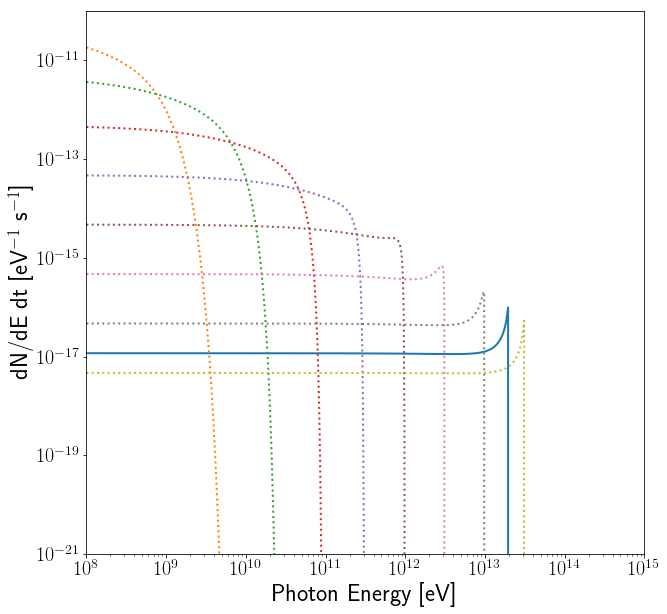

In [35]:
ax = plt.subplot(1,1,1)
plt.rc('text', usetex=True)

comp_elec_eng = np.array([2e13])

rel_ICS_tf.plot(ax, ind=comp_elec_eng, indtype='in_eng', linewidth=2)
rel_ICS_tf.plot(ax, ind=(0,80), step=10, indtype='ind',linewidth=2, linestyle=':')

ax.set_xscale('log')
ax.set_yscale('log')

plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlabel('Photon Energy [eV]',fontsize=24)

plt.ylabel('dN/dE dt [eV$^{-1}$ s$^{-1}$]',fontsize=24)
plt.axis([1e8, 1e15, 1e-21, 1e-10])

The electron spectrum from dark matter annihilating/decaying into muons is (from Tracy's notebook):

$$ \frac{dN_e}{dE_e} = \frac{12}{m_\mu} \left[ \frac{1}{4} \left( 1 - \frac{E_e^2}{E_\mu^2} \right) - \frac{1}{9} \left( 1 - \frac{E_e^3}{E_\mu^3} \right) \right] $$

and we can take $E_\mu = m_{\text{DM}}/2$. 